In [162]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
os.chdir("OriginalFromAllenDB")

In [166]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
from bmtool.synapses import SynapseTuner
from modules import spike_train_generation

In [5]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()

1.0

In [6]:
h.nrn_load_dll("modfiles/x86_64/.libs/libnrnmech.so")

0.0

In [ ]:

class AllenCell:
    def __init__(self, gid, soma_diam_multiplier=1.0):
        
        self._gid = gid
        self.synapses = []  # Keep track of all synapses
        self.netcons = []   # Keep track of NetCons
        self.stims = []     # Keep VecStims so they don't get garbage-collected
        self.vecs = []
        self.syn_locs = [] 
        
        description = Config().load('manifest.json')

        self.utils = Utils(description)
        self.h = self.utils.h
        self.Vinit = self.utils.description.data['conditions'][0]['v_init']
        # Cast all genome values to float
        for d in self.utils.description.data['genome']:
            if 'value' in d:
                d['value'] = float(d['value'])

        # Load morphology and parameters
        morphology_path = description.manifest.get_path('MORPHOLOGY')
        self.utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
        self.utils.load_cell_parameters()
        self.setup_morphology(soma_diam_multiplier)
        self._build_section_list()
    
    def setup_morphology(self,soma_diam_multiplier):

        self.soma = self.h.soma
        self.h.soma[0].diam *= soma_diam_multiplier
        self.dend = list(self.h.dend) if hasattr(self.h, 'dend') else []
        self.apic = list(self.h.apic) if hasattr(self.h, 'apic') else []
        self.axon = list(self.h.axon) if hasattr(self.h, 'axon') else []
        from neuron import h

        # Step 1: Set distance origin once (assuming soma(0.5) is your origin)
        h.distance(0, self.soma[0](0.5))

        # Step 2: Classify dendrites into proximal/distal
        self.proximal_dends = []
        self.distal_dends = []

        for sec in self.dend:  # assume this is your SectionList of dendrites
            # Use the midpoint of the section to define its distance
            dist = h.distance(sec(0.5))
            if dist >= 20:
                self.proximal_dends.append(sec)
            if dist >= 100:
                self.distal_dends.append(sec)


    def _build_section_list(self):
        self.all = h.SectionList()
        for sec in h.allsec():
            self.all.append(sec)
    ######### need proximal and distal list. or at least don't place any synapses close to the soma
    def add_random_synapses_from_df(self, df, syn_name, syn_params, section_pool=None):
        """
        Adds synapses at random locations with input times from a DataFrame.

        Parameters:
        - df: DataFrame with 'node' and 'timestamps' columns
        - syn_name: string name of NMODL synapse mechanism
        - syn_params: dictionary of synapse parameters (e.g. gmax, tau, e)
        - section_pool: list of sections to randomly choose from (default = self.dend)
        """
        if section_pool is None:
            section_pool = self.dend  # Default to dendrites
            
        self.full_list = []
        if type(section_pool) == list:
            for item in section_pool:
                self.full_list += item
            section_pool = self.full_list

        for _, row in df.iterrows():
            timestamps = row['timestamps']
            
            if not timestamps:
                continue

            sec = random.choice(section_pool)
            loc = random.uniform(0.1, 0.9)
            self.syn_locs.append((sec, loc))
            # Create synapse
            syn = getattr(h, syn_name)(sec(loc))
            for param, val in syn_params.items():
                if hasattr(syn, param):
                    setattr(syn, param, val)

            # Create VecStim with spike times
            vec = h.Vector(timestamps)
            self.vecs.append(vec)
            stim = h.VecStim()
            stim.play(vec)
            self.stims.append(stim)

            nc = h.NetCon(stim, syn)
            nc.weight[0] = syn_params.get('weight', 0.001)

            self.synapses.append(syn)
            self.netcons.append(nc)


            
    def __str__(self):
        return f"AllenCell(soma={self.soma}, dendrites={len(self.dend)})"

In [242]:
syn_params =  {
            'initW': 3,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.,
            'NMDA_ratio': 1.5
        }

In [147]:
PFR = pd.read_csv(os.path.join("..","pyrFiringRateAvg.csv"),delimiter=",")
PFR_time_shortened = np.array(PFR['Time'][PFR['Time'] >0])
PFR_firing_rate_shortened = np.array(PFR['AvgFiringRate'][PFR['Time'] >0])

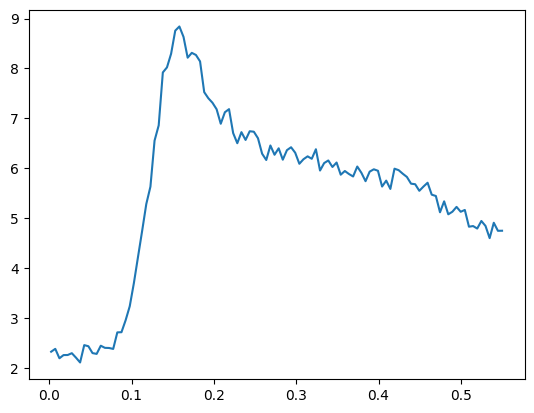

In [345]:
plt.plot(PFR_time_shortened,PFR_firing_rate_shortened)

In [168]:
def inhomogeneous_poisson_timestamps(lambdas, win_length, dt=1.0, start_time=0.0):
    """
    Generate spike timestamps using an inhomogeneous Poisson process.

    Parameters:
        lambdas (list or np.ndarray): firing rates for each time window (in Hz or per timestep).
        win_length (int): number of time steps per window.
        dt (float): duration of each time step in ms (or your preferred time unit).
        start_time (float): time offset (in ms) to start generating spikes.

    Returns:
        spike_times (list of float): spike timestamps across all windows.
    """
    spike_times = []
    for i, lambd in enumerate(lambdas):
        num_points = np.random.poisson(lambd)
        times_in_window = np.sort(np.random.uniform(0, win_length * dt, num_points))
        times_in_window += i * win_length * dt + start_time
        spike_times.extend(times_in_window.tolist())
    return spike_times

In [215]:
def get_num_spikes(freq,dur):
    return int(freq * (dur / 1000))

In [274]:
stim_start, stim_end = 100,1000
freqs = [5,20,50,100]
event_times = []
for freq in freqs:
    event_times.append(np.linspace(stim_start,stim_end, get_num_spikes(freq, stim_end-stim_start)))

In [300]:
cell = AllenCell(0,soma_diam_multiplier=6)
syn_params =  {
            'initW': 3,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.,
            'NMDA_ratio': 1.5
        }

ts, vs,ics = [],[],[]
for i, time in enumerate(event_times):
    
    syn = getattr(h, "AMPA_NMDA_STP")(cell.proximal_dends[0](0.5))
    for param, val in syn_params.items():
        if hasattr(syn, param):
            setattr(syn, param, val)
    vec = h.Vector(time)
    stim = h.VecStim()
    stim.play(vec)
    nc = h.NetCon(stim, syn)
    nc.weight[0] = syn_params.get('initW', 0.001)

    vc = h.VClamp(cell.soma[0](0.5))
    vc.dur[0] = 500   # ms
    vc.amp[0] = -65   # mV
    
    ic = h.Vector().record(vc._ref_i)
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

    # Simulation control
    h.finitialize(cell.Vinit)
    h.tstop = 1000.0  # ms
    h.run()
    
    ts.append(np.array(tvec))
    vs.append(np.array(vvec))
    ics.append(np.array(ic))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


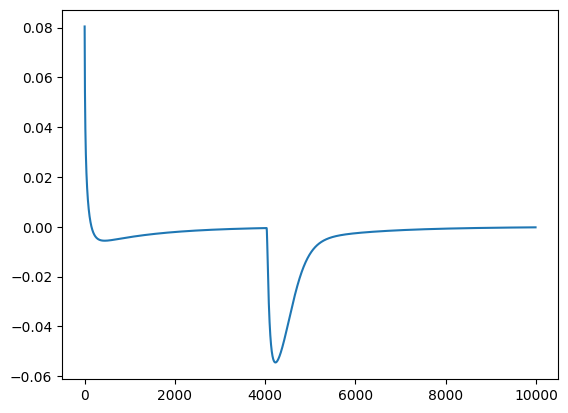

In [311]:
plt.plot(ics[0][10:10000])

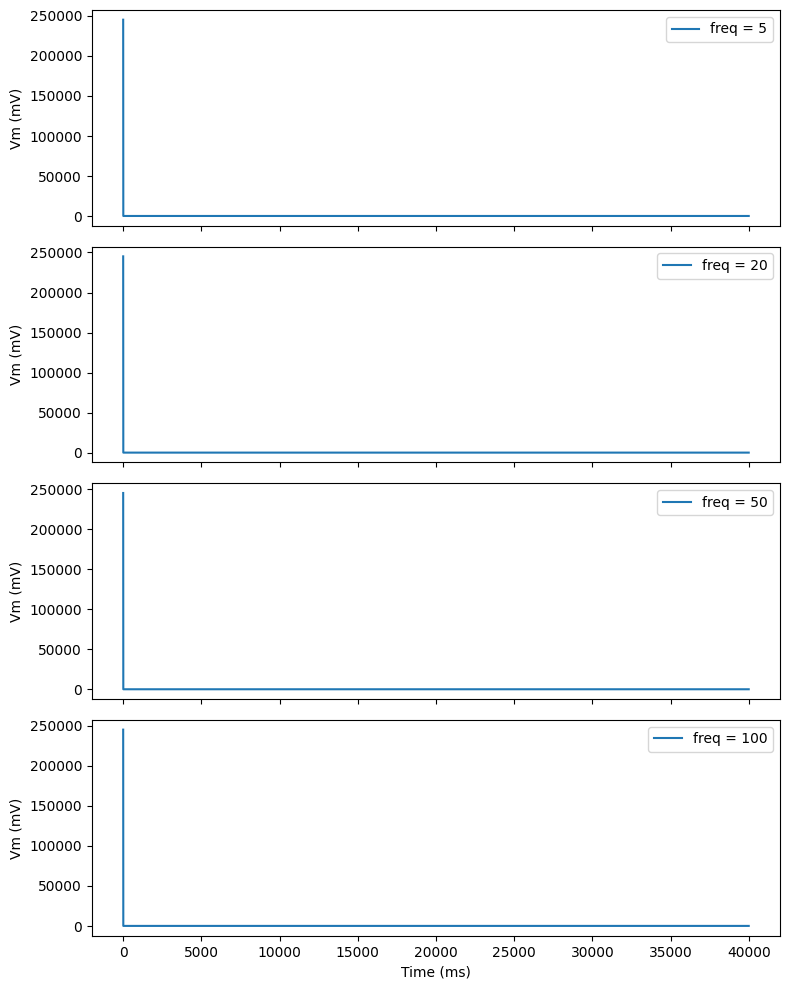

In [304]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

for i in range(4):
    T, V,Ics = np.array(ts[i]), np.array(vs[i]),np.array(ics[i])
    axes[i].plot(Ics, label=f"freq = {freqs[i]}")
    axes[i].set_ylabel("Vm (mV)")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


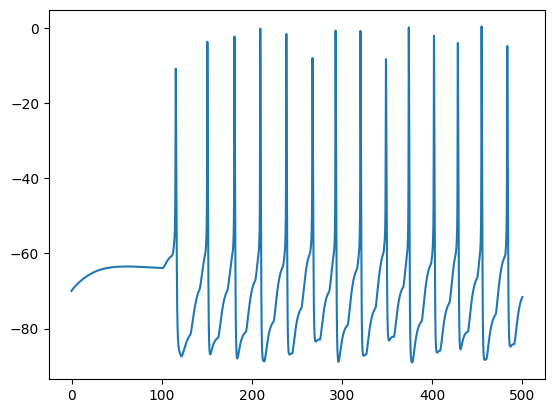

In [264]:
T,V = np.array(tvec),np.array(vvec)
plt.plot(T,V)

In [368]:
res = [ spike_train_generation.inhomogeneous_poisson_through_num_points(PFR_firing_rate_shortened*0.001,5)for i in range(1000)]

In [371]:
sum(res[0])

1.0

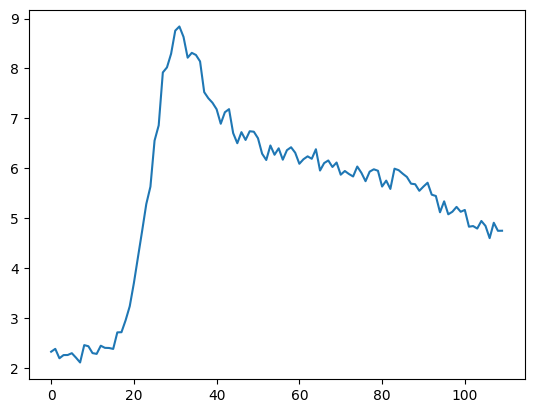

In [341]:
plt.plot(PFR_firing_rate_shortened)

In [414]:
N_stim = 50
all_spikes = []
all_spikes_binary = []

for i in range(N_stim):
    win_size = 5
    lambdas_array = PFR_firing_rate_shortened
    spikes = spike_train_generation.inhomogeneous_poisson_through_num_points(lambdas_array*0.001,int(win_size))
    all_spikes_binary.append(spikes)
    timestamps = inhomogeneous_poisson_timestamps(spikes,win_size,dt = 0.025,start_time=100 )
    all_spikes.append(timestamps)

df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_spikes) for t in times])
grouped_stim = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
len(grouped_stim["timestamps"][0])

1

In [471]:
array = np.repeat(5,650)
res = spike_train_generation.inhomogeneous_poisson_through_num_points(array,5)

In [477]:
sum(res) / 0.65

4021.5384615384614

In [472]:
np.average(res)

0.8043076923076923

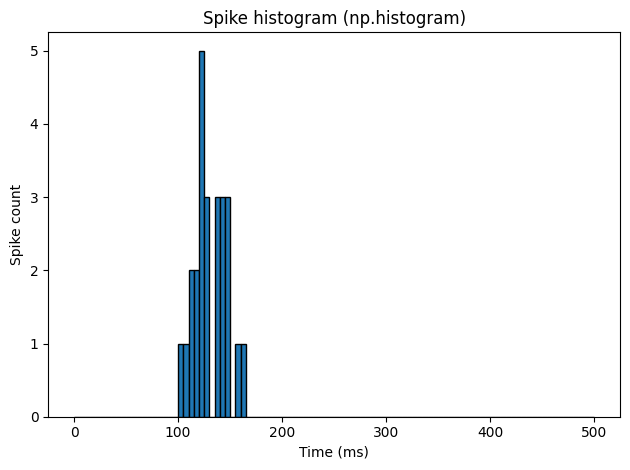

In [403]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the list of spike times
all_spike_times = [t for sublist in all_spikes if sublist for t in sublist]

# Define histogram bins (e.g., from 0 to 500 ms in 5 ms steps)
bins = np.arange(0, 505, 5)  # includes 500

# Compute histogram
counts, bin_edges = np.histogram(all_spike_times, bins=bins)

# Plot the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, counts, width=5, edgecolor='black')
plt.xlabel("Time (ms)")
plt.ylabel("Spike count")
plt.title("Spike histogram (np.histogram)")
plt.tight_layout()
plt.show()


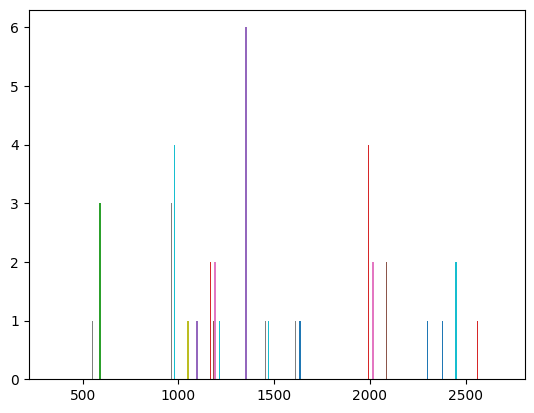

In [401]:
plt.hist(all_spikes,bins=5)
plt.show()

In [ ]:
PFR_firing_rate_shortened

In [459]:

N_background = 8000
all_bg_spikes = []
for i in range(N_background):
    background_spikes = spike_train_generation.homogeneous_poisson_timestamps(rate_hz=2, duration_ms=500)
    all_bg_spikes.append(background_spikes)

df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_bg_spikes) for t in times])
grouped = df.groupby('node_ids')['timestamps'].apply(list).reset_index()

print(grouped.shape)

(4487, 2)


In [460]:
spikes = []
for row in grouped['timestamps']:
    spikes.append(len(row))

In [461]:
sum(spikes) / N_background/0.4

2.0509375

In [ ]:
# num_neurons = 10
# psg = PoissonSpikeGenerator(population='example_pop', seed=32)

# for i in range(num_neurons):
#     psg.add(
#         node_ids=i,
#         firing_rate=PFR_firing_rate_shortened,
#         times=PFR_time_shortened
#     )

# spikes_df = psg.to_dataframe()
# print(f"Generated {len(spikes_df)} spikes across {num_neurons} neurons")

# firing_rates = []
# # Now loop over actual neuron IDs
# for node_id in range(num_neurons):
#     cell_spikes = spikes_df[spikes_df['node_ids'] == node_id]
#     duration = PFR_time_shortened[-1] - PFR_time_shortened[0]
#     firing_rate = len(cell_spikes) / duration
#     firing_rates.append(firing_rate)
#     # print(f"Neuron {node_id}: {len(cell_spikes)} spikes, mean rate = {firing_rate:.2f} Hz")

Generated 40 spikes across 10 neurons


In [192]:
cell = AllenCell(0,soma_diam_multiplier=6)
cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends,cell.distal_dends])

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [193]:
cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends])

In [194]:

print(f"Added {len(cell.synapses)} synapses")
for i, syn in enumerate(cell.synapses):
    print(f"Synapse {i}: {syn.get_segment().sec.name()} @ {syn.get_segment().x}")




Added 4397 synapses
Synapse 0: dend[24] @ 0.5
Synapse 1: dend[14] @ 0.1
Synapse 2: dend[12] @ 0.5
Synapse 3: dend[22] @ 0.7
Synapse 4: dend[44] @ 0.8333333333333334
Synapse 5: dend[23] @ 0.5
Synapse 6: dend[12] @ 0.5
Synapse 7: dend[39] @ 0.8333333333333334
Synapse 8: dend[1] @ 0.5
Synapse 9: dend[47] @ 0.5
Synapse 10: dend[24] @ 0.16666666666666666
Synapse 11: dend[6] @ 0.1
Synapse 12: dend[34] @ 0.16666666666666666
Synapse 13: dend[49] @ 0.5
Synapse 14: dend[13] @ 0.5
Synapse 15: dend[18] @ 0.7
Synapse 16: dend[24] @ 0.16666666666666666
Synapse 17: dend[50] @ 0.16666666666666666
Synapse 18: dend[7] @ 0.5
Synapse 19: dend[34] @ 0.8333333333333334
Synapse 20: dend[34] @ 0.16666666666666666
Synapse 21: dend[17] @ 0.5
Synapse 22: dend[14] @ 0.7
Synapse 23: dend[14] @ 0.5
Synapse 24: dend[35] @ 0.5
Synapse 25: dend[18] @ 0.1
Synapse 26: dend[6] @ 0.3
Synapse 27: dend[13] @ 0.5
Synapse 28: dend[51] @ 0.5
Synapse 29: dend[14] @ 0.3
Synapse 30: dend[17] @ 0.5
Synapse 31: dend[52] @ 0.1666666

In [ ]:

from neuron import h, gui  # gui not needed in headless scripts

# Set recording vectors
tvec = h.Vector().record(h._ref_t)
vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

# Simulation control
h.finitialize(cell.Vinit)
h.dt = 0.025
h.tstop = 500.0  # ms
h.run()


0.0

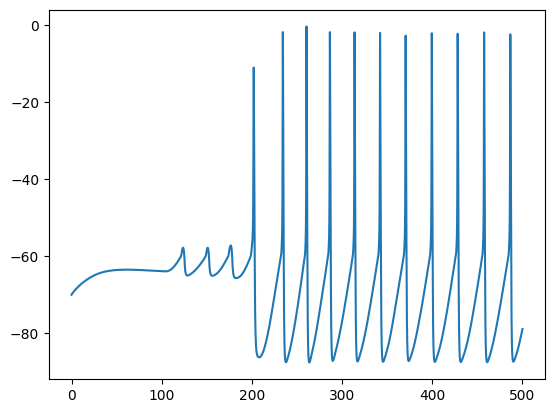

In [196]:
T,V = np.array(tvec),np.array(vvec)
plt.plot(T,V)
# plt.vlines(100,ymin=min(V),ymax=max(V),color = 'r')

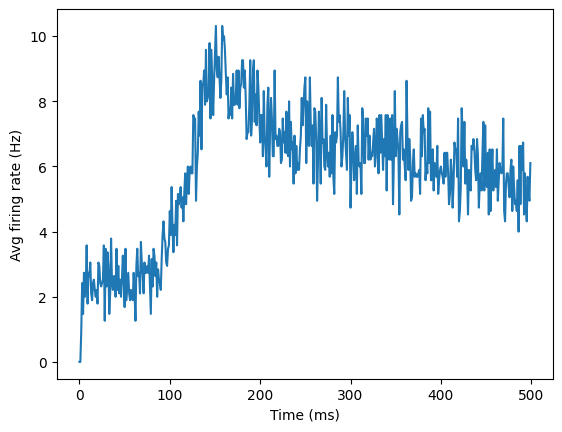

In [14]:


# Define time bins (assuming ms timestamps and 1 ms bins)
bin_size = 1  # in ms
times = np.arange(0, 500 + bin_size, bin_size)

# Histogram of spike counts per bin
spike_counts, _ = np.histogram(spikes_df['timestamps'], bins=times)

# Optional: Normalize to get firing rate
# If you have N neurons and you want average firing rate per neuron:
N_NEURONS = len(spikes_df['node_ids'].unique())
spike_rate = spike_counts / (bin_size / 1000) / N_NEURONS  # Convert ms to seconds

plt.plot(times[:-1], spike_rate)
plt.xlabel("Time (ms)")
plt.ylabel("Avg firing rate (Hz)")
plt.show()

